In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import json
from tqdm import tqdm

from glob import glob

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [3]:
sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

### Test on one image

In [5]:
image = (plt.imread('../images/selected_images/lion/00114-1158672415.png')*255).astype(np.uint8)
predictor.set_image(image)

In [6]:
input_point = np.array([[256, 256]])
input_label = np.array([1])

In [7]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

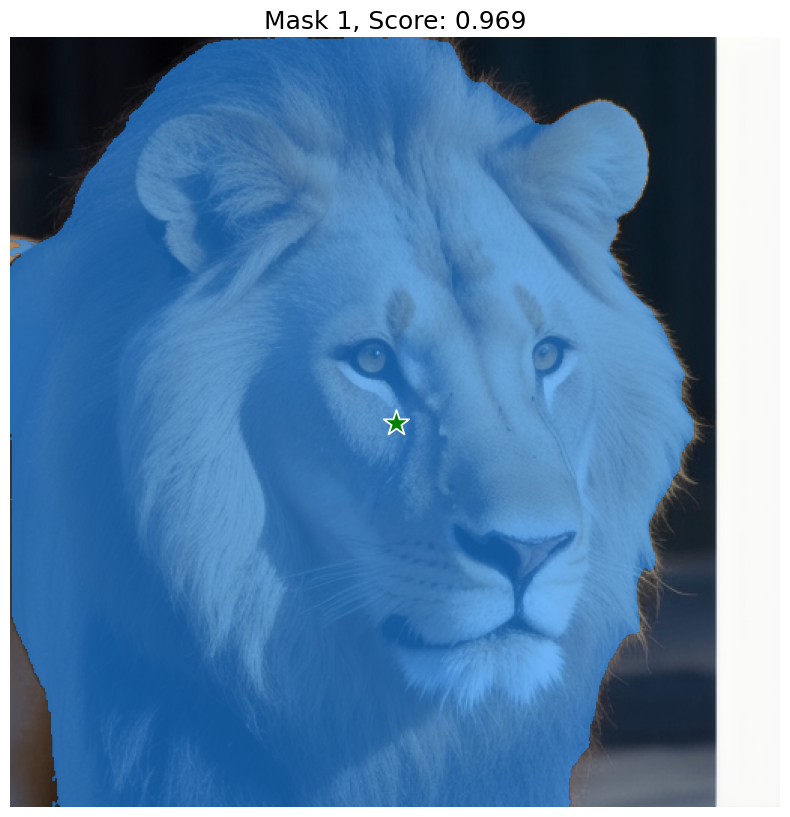

In [8]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

### Run on all images

In [10]:
images = glob('../images/selected_images/*/*.png')
multimask = True
save_mask_only = True
output_folder = '../images/masks/'

input_point = np.array([[256, 256]])
input_label = np.array([1])

for idx in range(len(images)):
    image = (plt.imread(images[idx])*255).astype(np.uint8)
    predictor.set_image(image)

    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
    )

    if multimask:
        mask = masks[scores.argmax()]
    else:
        mask = masks[0]
    filename = images[idx].split("/")[-1].split('.')[0]
    output_path = f"{output_folder}/multimask__{multimask}{filename}.jpg"
    if save_mask_only:
        plt.imsave(output_path, mask)
    else:
        fig = plt.figure()
        plt.imshow(image)
        show_mask(mask, plt.gca())
        show_box(bboxes[idx_mask][1:], plt.gca())
        plt.axis('off')
        plt.savefig('overlay_output/' + output_path)
        plt.close(fig)
